# CIS 5450 Final Project Part 2: Learning Recommendation Engine

Group Members: Jin Kun Li, Daniel Leng, Smiti Srinivasan, Son Tung Nguyen

The 2022 Stack Overflow Developer Survey is a wealth of information on developer demographics, tools they use, and their preferences. As current students asipiring to switch to careers involving coding, we want to answer the following question: what language/framework/platform should we learn next to ensure we are competitive with peers in the field?

Using the developer survey results, we have designed a k-means model that uses demographic inputs to generate a set of languages/frameworks/etc that peers have already learned, and use that information to recommend areas of learning to fill gaps in knowledge.

# **Part 1: Data Cleaning and Wrangling**

In [ ]:
# this code block contains all needed imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections.abc import Iterable
import collections

## 1.1 Download Data from Kaggle

The developer survey results are available on Kaggle. The following code blocks will download the csv files from Kaggle mostly reusing code from Homework 4.

In [ ]:
# mount google drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the kaggle directory and
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!!kaggle datasets download -d ebrahimelgazar/stack-overflow-2022-developer-survey

['Downloading stack-overflow-2022-developer-survey.zip to /content',
 '',
 '  0% 0.00/11.7M [00:00<?, ?B/s]',
 ' 43% 5.00M/11.7M [00:00<00:00, 37.9MB/s]',
 '',
 '100% 11.7M/11.7M [00:00<00:00, 71.2MB/s]']

In [ ]:
# Unzip folder in Colab content folder
!unzip /content/stack-overflow-2022-developer-survey.zip

Archive:  /content/stack-overflow-2022-developer-survey.zip
  inflating: README_2022.txt         
  inflating: survey_results_public.csv  
  inflating: survey_results_schema.csv  


## 1.2 Load Data into Dataframes

There are two csv files that come with the dataset.
*   **survey_results_public.csv** contains the responses from the survey
*   **survey_results_schema.csv** contains the exact question asked in the survey

We only loaded the data csv here, but the idea is to cross reference each column with the schema csv to understand the significance of results and whether to keep each column in the final cleaned dataset.



In [ ]:
# read the csv file as pandas dataframe
df_survey_public_raw = pd.read_csv("/content/survey_results_public.csv")

Below you will see some info on the responses:
*   79 columns, most of them aligned with specific questions from the survey
*   73,268 responses, but not all the responses answered every question. Given the large variation in what is answered, we need to be careful about cleaning data so we do not lose too many rows
*   Some responses that are usually numbers are instead coded as objects (example is age). We need to examine these responses in detail to understand why and what cleaning is required
*   There are likely too many features to use everything in our recommendation engine, so we will need to use judgment to remove features that are less useful



In [ ]:
df_survey_public_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73268 entries, 0 to 73267
Data columns (total 79 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ResponseId                      73268 non-null  int64  
 1   MainBranch                      73268 non-null  object 
 2   Employment                      71709 non-null  object 
 3   RemoteWork                      58958 non-null  object 
 4   CodingActivities                58899 non-null  object 
 5   EdLevel                         71571 non-null  object 
 6   LearnCode                       71580 non-null  object 
 7   LearnCodeOnline                 50685 non-null  object 
 8   LearnCodeCoursesCert            29389 non-null  object 
 9   YearsCode                       71331 non-null  object 
 10  YearsCodePro                    51833 non-null  object 
 11  DevType                         61302 non-null  object 
 12  OrgSize                         

## 1.3 Dropping Unneeded Features and Cleaning the Data

Below we picked 16 features to keep and use in the recommendation engine. Some reasons why we dropped the other columns:
*   We don't care about individual ids because we are looking for aggregate trends.
*   Many of the features are specifically about Stack Overflow. Recommending languages and frameworks to study based on how often someone uses Stack Overflow doesn't sound like a great idea.
*   Removed all the "WantToWorkWith" features because we only want to recommend languages and frameworks that peers are already using.
*   Some demographic questions like Sexuality and Ethnicity were dropped because we do not want to recommend languages to learn based on these features.
*   Some features we would have liked to include, but dropped due to relatively lower number of responses (Manager vs Individual Contributor is an example)
*   Some features are very similar with other features, so we usually kept one and dropped the others.



In [ ]:
# remove unneeded columns and save copy to new df
# note: we include WorkExp as a feature but won't actually be using it in our final data because it has many nulls and YearsCodePro is very similar
df_survey_public_rec_cond = df_survey_public_raw[["Employment", "RemoteWork", "CodingActivities", "LearnCode", "YearsCode", "YearsCodePro", "DevType", "OrgSize",
                                                  "LanguageHaveWorkedWith", "DatabaseHaveWorkedWith", "PlatformHaveWorkedWith", "WebframeHaveWorkedWith",
                                                  "MiscTechHaveWorkedWith", "Age", "Country", "WorkExp"]].copy()

In [ ]:
df_survey_public_rec_cond.shape

(73268, 16)

Dropping all rows with any feature having null would leave us with a dataset that is too small.

We are creating a recommendation engine, so our recommendations will be using the "HaveWorkedWith" features. We will drop any rows that don't have any responses to all of the "HaveWorkedWith" features. A response that knows no languages so is not useful in our recommendation engine. If a row has some of the "HaveWorkedWith" features as null, that is fine because we can assume that they have not worked with any of those technologies.

In [ ]:
# drop rows where all "HaveWorkedWith" columns are NaN
df_survey_public_rec_cond_6 = df_survey_public_rec_cond.dropna(how="all", subset=["LanguageHaveWorkedWith", "DatabaseHaveWorkedWith", "PlatformHaveWorkedWith",
                                                                                            "WebframeHaveWorkedWith", "MiscTechHaveWorkedWith"])
df_survey_public_rec_cond_6.shape

(71232, 16)

In [ ]:
df_survey_public_rec_cond_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71232 entries, 1 to 73267
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Employment              71176 non-null  object 
 1   RemoteWork              58752 non-null  object 
 2   CodingActivities        58698 non-null  object 
 3   LearnCode               71066 non-null  object 
 4   YearsCode               70837 non-null  object 
 5   YearsCodePro            51707 non-null  object 
 6   DevType                 61019 non-null  object 
 7   OrgSize                 50937 non-null  object 
 8   LanguageHaveWorkedWith  70975 non-null  object 
 9   DatabaseHaveWorkedWith  60121 non-null  object 
 10  PlatformHaveWorkedWith  49924 non-null  object 
 11  WebframeHaveWorkedWith  53544 non-null  object 
 12  MiscTechHaveWorkedWith  44992 non-null  object 
 13  Age                     70455 non-null  object 
 14  Country                 71232 non-null

**Employment** is the first of many columns that need to be hot encoded. A recurring issue we will find in the data is many features can contain multiple answers. For example: a response can include "Employed, full-time" and "Student, part-time". This means we need to be a bit creative with our one hot encoding process.

Here is the process we will use for most one hot encoding for the rest of this notebook:
1.   Split out all answers to get idea of how many unique answers are available
2.   Combine answers when they are similar to minimize number of columns
3.   One hot encode each column by searching for substring



In [ ]:
# drop NA values in employment feature
df_survey_public_rec_cond_6 = df_survey_public_rec_cond_6.dropna(subset=["Employment"])
df_survey_public_rec_cond_6.shape

(71176, 16)

In [ ]:
# see all unique answers in employement feature
df_employment = df_survey_public_rec_cond_6["Employment"].str.split(";", expand=True).stack().drop_duplicates()
df_employment

1    0                                  Employed, full-time
5    0                                   Student, full-time
6    0                                   Student, part-time
7    0                   Not employed, but looking for work
9    0    Independent contractor, freelancer, or self-em...
13   0                                  Employed, part-time
27   0               Not employed, and not looking for work
77   0                                              Retired
125  0                                  I prefer not to say
dtype: object

In [ ]:
# one hot encode the employment column
# we also want to keep number of columns at a minimum, so we will combine part-time and full-time responses
df_survey_public_rec_cond_6["Employed"] = df_survey_public_rec_cond_6["Employment"].apply(lambda x: 1 if "Employed," in x else 0)
df_survey_public_rec_cond_6["Student"] = df_survey_public_rec_cond_6["Employment"].apply(lambda x: 1 if "Student," in x else 0)
df_survey_public_rec_cond_6["Contractor"] = df_survey_public_rec_cond_6["Employment"].apply(lambda x: 1 if "Independent" in x else 0)
df_survey_public_rec_cond_6["NotEmployed"] = df_survey_public_rec_cond_6["Employment"].apply(lambda x: 1 if "Not employed" in x else 0)
df_survey_public_rec_cond_6["Retired"] = df_survey_public_rec_cond_6["Employment"].apply(lambda x: 1 if "Retired" in x else 0)

In [ ]:
# check if the one hot encode makes sense
print(df_survey_public_rec_cond_6[(df_survey_public_rec_cond_6["Employed"] == 1) & (df_survey_public_rec_cond_6["NotEmployed"] == 1)].shape)
print(df_survey_public_rec_cond_6[(df_survey_public_rec_cond_6["Employed"] == 0) &
                                  (df_survey_public_rec_cond_6["NotEmployed"] == 0) &
                                  (df_survey_public_rec_cond_6["Contractor"] == 0) &
                                  (df_survey_public_rec_cond_6["Student"] == 0) &
                                  (df_survey_public_rec_cond_6["Retired"] == 0)].shape)

(121, 21)
(580, 21)


In [ ]:
# drop rows where employment is not given
df_survey_public_rec_cond_6 = df_survey_public_rec_cond_6[(df_survey_public_rec_cond_6["Employed"] == 1) |
                                                          (df_survey_public_rec_cond_6["NotEmployed"] == 1) |
                                                          (df_survey_public_rec_cond_6["Contractor"] == 1) |
                                                          (df_survey_public_rec_cond_6["Student"] == 1) |
                                                          (df_survey_public_rec_cond_6["Retired"] == 1)]
df_survey_public_rec_cond_6.shape

(70596, 21)

**RemoteWork** has more null responses than employment. In the below investigation, we found that the majority of the null responses are from people who are retired, not employed, or a student. This makes sense so we do not need to drop these rows.

In [ ]:
df_survey_public_rec_cond_6["RemoteWork"].value_counts()

Fully remote                            25275
Hybrid (some remote, some in-person)    24936
Full in-person                           8541
Name: RemoteWork, dtype: int64

In [ ]:
# number of null responses
df_remote_na = df_survey_public_rec_cond_6[df_survey_public_rec_cond_6["RemoteWork"].isna()]
df_remote_na.shape

(11844, 21)

In [ ]:
# we can see small amount of rows where people employed didn't answer remote work question
# we should remove these lines
print(df_remote_na[df_remote_na["Employed"] == 1].shape)
print(df_remote_na[df_remote_na["Contractor"] == 1].shape)
df_survey_public_rec_cond_6 = df_survey_public_rec_cond_6[(df_survey_public_rec_cond_6["NotEmployed"] == 1) |
                                                          (df_survey_public_rec_cond_6["Student"] == 1) |
                                                          (df_survey_public_rec_cond_6["Retired"] == 1) |
                                                          (df_survey_public_rec_cond_6["RemoteWork"].notna())]
print(df_survey_public_rec_cond_6.shape)

(13, 21)
(26, 21)
(70596, 24)


In [ ]:
# one hot encode
df_survey_public_rec_cond_6["RemoteWork"] = df_survey_public_rec_cond_6["RemoteWork"].fillna("NA")
df_survey_public_rec_cond_6["Remote"] = df_survey_public_rec_cond_6["RemoteWork"].apply(lambda x: 1 if "Fully" in x else 0)
df_survey_public_rec_cond_6["Hybrid"] = df_survey_public_rec_cond_6["RemoteWork"].apply(lambda x: 1 if "Hybrid" in x else 0)
df_survey_public_rec_cond_6["InPerson"] = df_survey_public_rec_cond_6["RemoteWork"].apply(lambda x: 1 if "Full in-person" in x else 0)

In [ ]:
# our dataset is starting to come together
df_survey_public_rec_cond_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70596 entries, 1 to 73267
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Employment              70596 non-null  object 
 1   RemoteWork              70596 non-null  object 
 2   CodingActivities        58698 non-null  object 
 3   LearnCode               70450 non-null  object 
 4   YearsCode               70240 non-null  object 
 5   YearsCodePro            51548 non-null  object 
 6   DevType                 61019 non-null  object 
 7   OrgSize                 50778 non-null  object 
 8   LanguageHaveWorkedWith  70356 non-null  object 
 9   DatabaseHaveWorkedWith  59712 non-null  object 
 10  PlatformHaveWorkedWith  49628 non-null  object 
 11  WebframeHaveWorkedWith  53157 non-null  object 
 12  MiscTechHaveWorkedWith  44642 non-null  object 
 13  Age                     69878 non-null  object 
 14  Country                 70596 non-null

**Coding activities** is a bit more complicated to clean. When we look at the lines without responses, there doesn't seem to be a pattern of why responses didn't include this question. However, it is possible some people do not code whatsoever and that is not available as a response. Therefore, we will leave the null responses as is and not fill in any data.

In [ ]:
df_coding_activities = df_survey_public_rec_cond_6["CodingActivities"].str.split(";", expand=True).stack().drop_duplicates()
df_coding_activities

1     0                                 Hobby
      1    Contribute to open-source projects
3     0          I don’t code outside of work
9     2              Bootstrapping a business
11    2               Freelance/contract work
45    0               Other (please specify):
1472  3               School or academic work
dtype: object

In [ ]:
df_not_coding = df_survey_public_rec_cond_6[df_survey_public_rec_cond_6["CodingActivities"].isna()]
df_not_coding.head()

,Employment,RemoteWork,CodingActivities,LearnCode,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,...,Country,WorkExp,Employed,Student,Contractor,NotEmployed,Retired,Remote,Hybrid,InPerson
5,"Student, full-time",NA,NaN,"Books / Physical media;School (i.e., Universit...",15,NaN,NaN,NaN,C++;Lua,NaN,...,Germany,NaN,0,1,0,0,0,0,0,0
6,"Student, part-time",NA,NaN,"Other online resources (e.g., videos, blogs, f...",3,NaN,NaN,NaN,C++;HTML/CSS;JavaScript;PHP;Python;TypeScript,Cloud Firestore;MongoDB;Firebase Realtime Data...,...,India,NaN,0,1,0,0,0,0,0,0
7,"Not employed, but looking for work",NA,NaN,Online Courses or Certification,1,NaN,"Developer, full-stack;Student",NaN,C;C++;HTML/CSS;Java;JavaScript;SQL,MongoDB;MySQL,...,India,NaN,0,0,0,1,0,0,0,0
19,"Student, full-time",NA,NaN,Books / Physical media;Coding Bootcamp;Colleague,2,NaN,NaN,NaN,C++;HTML/CSS;Java;JavaScript;Python,MySQL,...,Serbia,NaN,0,1,0,0,0,0,0,0
27,"Not employed, and not looking for work",NA,NaN,"Other online resources (e.g., videos, blogs, f...",4,NaN,NaN,NaN,C#;HTML/CSS;JavaScript;Rust;TypeScript,Microsoft SQL Server;PostgreSQL,...,Israel,NaN,0,0,0,1,0,0,0,0


In [ ]:
# since there doesn't appear to be any kind of pattern, will keep na rows
# one hot encode responses
df_survey_public_rec_cond_6["CodingActivities"] = df_survey_public_rec_cond_6["CodingActivities"].fillna("NA")
df_survey_public_rec_cond_6["CodingHobby"] = df_survey_public_rec_cond_6["CodingActivities"].apply(lambda x: 1 if "Hobby" in x else 0)
df_survey_public_rec_cond_6["CodingProjects"] = df_survey_public_rec_cond_6["CodingActivities"].apply(lambda x: 1 if "projects" in x else 0)
df_survey_public_rec_cond_6["CodingSideBusiness"] = df_survey_public_rec_cond_6["CodingActivities"].apply(lambda x: 1 if ("business" in x) or
                                                                                                    ("Freelance" in x) else 0)
df_survey_public_rec_cond_6["CodingSideSchool"] = df_survey_public_rec_cond_6["CodingActivities"].apply(lambda x: 1 if "School" in x else 0)
df_survey_public_rec_cond_6["CodingOther"] = df_survey_public_rec_cond_6["CodingActivities"].apply(lambda x: 1 if x and "Other" in x else 0)

In [ ]:
df_survey_public_rec_cond_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70596 entries, 1 to 73267
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Employment              70596 non-null  object 
 1   RemoteWork              70596 non-null  object 
 2   CodingActivities        70596 non-null  object 
 3   LearnCode               70450 non-null  object 
 4   YearsCode               70240 non-null  object 
 5   YearsCodePro            51548 non-null  object 
 6   DevType                 61019 non-null  object 
 7   OrgSize                 50778 non-null  object 
 8   LanguageHaveWorkedWith  70356 non-null  object 
 9   DatabaseHaveWorkedWith  59712 non-null  object 
 10  PlatformHaveWorkedWith  49628 non-null  object 
 11  WebframeHaveWorkedWith  53157 non-null  object 
 12  MiscTechHaveWorkedWith  44642 non-null  object 
 13  Age                     69878 non-null  object 
 14  Country                 70596 non-null

**LearnCode** will be cleaned similar to the ones above.

In [ ]:
df_learn_code = df_survey_public_rec_cond_6["LearnCode"].str.split(";", expand=True).stack().drop_duplicates()
df_learn_code

2   0                               Books / Physical media
    1                              Friend or family member
    2    Other online resources (e.g., videos, blogs, f...
    3              School (i.e., University, College, etc)
4   2                                  On the job training
7   0                      Online Courses or Certification
16  4                                            Colleague
18  3                                      Coding Bootcamp
21  0                              Other (please specify):
54  4                    Hackathons (virtual or in-person)
dtype: object

In [ ]:
# remove NAs from LearnCode
df_survey_public_rec_cond_6 = df_survey_public_rec_cond_6[df_survey_public_rec_cond_6["LearnCode"].notna()]
df_survey_public_rec_cond_6.shape

(70450, 29)

In [ ]:
# one hot encode LearnCode
df_survey_public_rec_cond_6["LearnBooks"] = df_survey_public_rec_cond_6["LearnCode"].apply(lambda x: 1 if "Books" in x else 0)
df_survey_public_rec_cond_6["LearnFriendFamily"] = df_survey_public_rec_cond_6["LearnCode"].apply(lambda x: 1 if "Friend" in x else 0)
df_survey_public_rec_cond_6["LearnOnline"] = df_survey_public_rec_cond_6["LearnCode"].apply(lambda x: 1 if "online" in x.lower() else 0)
df_survey_public_rec_cond_6["LearnSchool"] = df_survey_public_rec_cond_6["LearnCode"].apply(lambda x: 1 if "School" in x else 0)
df_survey_public_rec_cond_6["LearnJob"] = df_survey_public_rec_cond_6["LearnCode"].apply(lambda x: 1 if ("job" in x) or
                                                                                         ("Colleague" in x) else 0)
df_survey_public_rec_cond_6["LearnBootcamp"] = df_survey_public_rec_cond_6["LearnCode"].apply(lambda x: 1 if "Bootcamp" in x else 0)
df_survey_public_rec_cond_6["LearnHackathon"] = df_survey_public_rec_cond_6["LearnCode"].apply(lambda x: 1 if "Hack" in x else 0)
df_survey_public_rec_cond_6["LearnOther"] = df_survey_public_rec_cond_6["LearnCode"].apply(lambda x: 1 if "Other (please" in x else 0)

In [ ]:
df_survey_public_rec_cond_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70450 entries, 2 to 73267
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Employment              70450 non-null  object 
 1   RemoteWork              70450 non-null  object 
 2   CodingActivities        70450 non-null  object 
 3   LearnCode               70450 non-null  object 
 4   YearsCode               70158 non-null  object 
 5   YearsCodePro            51500 non-null  object 
 6   DevType                 60954 non-null  object 
 7   OrgSize                 50719 non-null  object 
 8   LanguageHaveWorkedWith  70216 non-null  object 
 9   DatabaseHaveWorkedWith  59610 non-null  object 
 10  PlatformHaveWorkedWith  49546 non-null  object 
 11  WebframeHaveWorkedWith  53070 non-null  object 
 12  MiscTechHaveWorkedWith  44583 non-null  object 
 13  Age                     69769 non-null  object 
 14  Country                 70450 non-null

**YearsCode** and **YearsCodePro** are a bit different from the features above. These two are the first features that should be numbers, but you can see there are some non-number responses below.

We can replace "Less than 1 year" with 0 years and replace "More than 50 years" with 51 years to allow the feature to be numbers. Although some of the 50+ years responses might be more than 51 years, it is impossible for us to know how many years and there are few responses so it will have minimal impact on our model.

In [ ]:
df_survey_public_rec_cond_6["YearsCode"].value_counts()

10                    5173
5                     5099
6                     4604
4                     4382
7                     4204
8                     4196
3                     3994
2                     3219
12                    2979
15                    2950
20                    2632
9                     2567
11                    1806
14                    1796
13                    1612
25                    1574
1                     1471
16                    1399
30                    1321
22                    1171
Less than 1 year      1170
18                    1147
17                    1072
40                     770
24                     748
35                     735
23                     640
19                     562
26                     487
27                     482
21                     478
28                     420
32                     366
38                     284
37                     274
34                     238
36                     235
3

In [ ]:
df_survey_public_rec_cond_6["YearsCodePro"].value_counts()

3                     4234
5                     4035
2                     3908
4                     3857
10                    3311
6                     3177
7                     2749
8                     2637
1                     2621
Less than 1 year      1935
15                    1808
12                    1704
9                     1578
20                    1459
11                    1363
14                    1044
22                     928
16                     917
13                     909
25                     873
18                     784
17                     720
30                     565
23                     459
24                     454
21                     428
19                     379
26                     318
27                     282
35                     263
28                     254
32                     220
40                     172
29                     125
33                     122
31                     120
34                     112
3

In [ ]:
# replace less than 1 year with 0
df_survey_public_rec_cond_6["YearsCode"] = df_survey_public_rec_cond_6["YearsCode"].apply(lambda x: 0 if x == "Less than 1 year" else x)
df_survey_public_rec_cond_6["YearsCodePro"] = df_survey_public_rec_cond_6["YearsCodePro"].apply(lambda x: 0 if x == "Less than 1 year" else x)

# replace more than 50 years with 51
df_survey_public_rec_cond_6["YearsCode"] = df_survey_public_rec_cond_6["YearsCode"].apply(lambda x: 51 if x == "More than 50 years" else x)
df_survey_public_rec_cond_6["YearsCodePro"] = df_survey_public_rec_cond_6["YearsCodePro"].apply(lambda x: 51 if x == "More than 50 years" else x)

In [ ]:
df_survey_public_rec_cond_6 = df_survey_public_rec_cond_6[df_survey_public_rec_cond_6["YearsCode"].notna()]
df_survey_public_rec_cond_6.shape

(70158, 37)

In [ ]:
# fill NA in YearsCodePro with 0 (we are assuming that if someone doesn't answer, then they have no professional coding experience)
df_survey_public_rec_cond_6["YearsCodePro"] = df_survey_public_rec_cond_6["YearsCodePro"].fillna(0)

**YearsCode** and **YearsCodePro** can be very correlated because YearsCode should include YearsCodePro. To avoid this correlation, we will create a few feature that specifically track non professional years of coding.

In [ ]:
# add column to track non-working years of coding
df_survey_public_rec_cond_6["YearsCode"] = df_survey_public_rec_cond_6["YearsCode"].astype("int64")
df_survey_public_rec_cond_6["YearsCodePro"] = df_survey_public_rec_cond_6["YearsCodePro"].astype("int64")
df_survey_public_rec_cond_6["YearsCodeOther"] = df_survey_public_rec_cond_6["YearsCode"] - df_survey_public_rec_cond_6["YearsCodePro"]

In [ ]:
# remove rows with negative values because the data wouldn't make sense
df_survey_public_rec_cond_6[df_survey_public_rec_cond_6["YearsCodeOther"] < 0].shape
df_survey_public_rec_cond_6 = df_survey_public_rec_cond_6[df_survey_public_rec_cond_6["YearsCodeOther"] >= 0]
df_survey_public_rec_cond_6.shape

(69624, 38)

In [ ]:
# here is current status of the data
df_survey_public_rec_cond_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69624 entries, 2 to 73267
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Employment              69624 non-null  object 
 1   RemoteWork              69624 non-null  object 
 2   CodingActivities        69624 non-null  object 
 3   LearnCode               69624 non-null  object 
 4   YearsCode               69624 non-null  int64  
 5   YearsCodePro            69624 non-null  int64  
 6   DevType                 60200 non-null  object 
 7   OrgSize                 50029 non-null  object 
 8   LanguageHaveWorkedWith  69400 non-null  object 
 9   DatabaseHaveWorkedWith  58879 non-null  object 
 10  PlatformHaveWorkedWith  48953 non-null  object 
 11  WebframeHaveWorkedWith  52447 non-null  object 
 12  MiscTechHaveWorkedWith  44076 non-null  object 
 13  Age                     68982 non-null  object 
 14  Country                 69624 non-null

**DevType** has many different responses, so we will try to simplify the responses into a few features.

In [ ]:
df_dev_type = df_survey_public_rec_cond_6["DevType"].str.split(";", expand=True).stack().drop_duplicates()
df_dev_type

2   0     Data scientist or machine learning specialist
    1                              Developer, front-end
    2                                    Engineer, data
    3                        Engineer, site reliability
3   0                             Developer, full-stack
4   2                               Developer, back-end
    3     Developer, desktop or enterprise applications
    4                             Developer, QA or test
7   1                                           Student
9   1                                 Developer, mobile
    2                                          Educator
11  0                               Engineering manager
13  3                            Database administrator
14  1                               Academic researcher
    2                                 DevOps specialist
23  0                           Other (please specify):
28  1       Developer, embedded applications or devices
    2                       Developer, game or g

In [ ]:
# we can see most of the null responses for DevType come from those who are not employed or are not an independent contractor
df_dev_type_na = df_survey_public_rec_cond_6[df_survey_public_rec_cond_6["DevType"].isna()]
print(df_dev_type_na.shape)
print(df_dev_type_na[df_dev_type_na["Employed"] == 1].shape)
print(df_dev_type_na[df_dev_type_na["Contractor"] == 1].shape)

(9424, 38)
(141, 38)
(47, 38)


In [ ]:
# drop employed and contractor rows that don't have dev type response because the data doesn't make sense
df_survey_public_rec_cond_6 = df_survey_public_rec_cond_6[df_survey_public_rec_cond_6["DevType"].notna() |
                                                          (df_survey_public_rec_cond_6["Student"] == 1) |
                                                          (df_survey_public_rec_cond_6["Retired"] == 1) |
                                                          (df_survey_public_rec_cond_6["NotEmployed"] == 1)].copy()
df_survey_public_rec_cond_6.shape

(69484, 38)

In [ ]:
df_survey_public_rec_cond_6["DevType"] = df_survey_public_rec_cond_6["DevType"].fillna("NA")
df_survey_public_rec_cond_6["TypeDevEng"] = df_survey_public_rec_cond_6.apply(lambda row: 1 if ("dev" in row["DevType"].lower()) |
                                                                              ("engineer" in row["DevType"].lower()) else 0, axis=1)
df_survey_public_rec_cond_6["TypeData"] = df_survey_public_rec_cond_6.apply(lambda row: 1 if ("data" in row["DevType"].lower()) else 0, axis=1)
df_survey_public_rec_cond_6["TypeManager"] = df_survey_public_rec_cond_6.apply(lambda row: 1 if ("manager" in row["DevType"].lower()) |
                                                                               ("executive" in row["DevType"].lower()) else 0, axis=1)
df_survey_public_rec_cond_6["TypeOther"] = df_survey_public_rec_cond_6.apply(lambda row: 1 if ("educator" in row["DevType"].lower()) |
                                                                             ("researcher" in row["DevType"].lower()) |
                                                                             ("other" in row["DevType"].lower()) |
                                                                             ("designer" in row["DevType"].lower()) |
                                                                             ("Scientist" in row["DevType"]) |
                                                                             ("system administrator" in row["DevType"].lower()) |
                                                                             ("blockchain" in row["DevType"].lower()) |
                                                                             ("professional" in row["DevType"].lower()) else 0, axis=1)

**Age** is the next feature that should be numbers. Examining the responses tells us that the survey provided ranges, which is why each response is a string. It doesn't make sense to one hot encode age, so we will replace each of the responses with the middle age in the range.

In [ ]:
df_survey_public_rec_cond_6["Age"].value_counts()

25-34 years old       27451
18-24 years old       16190
35-44 years old       13634
45-54 years old        5140
Under 18 years old     3597
55-64 years old        1930
65 years or older       528
Prefer not to say       378
Name: Age, dtype: int64

In [ ]:
# drop rows where age was not input
df_survey_public_rec_cond_6 = df_survey_public_rec_cond_6.dropna(subset=["Age"])
df_survey_public_rec_cond_6.shape

(68848, 42)

In [ ]:
# map Age values to number
# for ones that preferred to not say, fill with median age
age_map = {
    "25-34 years old": 30,
    "18-24 years old": 21,
    "35-44 years old": 40,
    "45-54 years old": 50,
    "Under 18 years old": 16,
    "55-64 years old": 60,
    "65 years or older": 70
}
df_survey_public_rec_cond_6["AgeNum"] = df_survey_public_rec_cond_6["Age"].map(age_map)
age_median = df_survey_public_rec_cond_6["AgeNum"].median()
print("Median age:", age_median)
df_survey_public_rec_cond_6["AgeNum"] = df_survey_public_rec_cond_6["AgeNum"].fillna(age_median)
df_survey_public_rec_cond_6["AgeNum"].value_counts()

Median age: 30.0


30.0    27829
21.0    16190
40.0    13634
50.0     5140
16.0     3597
60.0     1930
70.0      528
Name: AgeNum, dtype: int64

**OrgSize** is cleaned similar to Age

In [ ]:
org_map = {
    "20 to 99 employees": 59,
    "100 to 499 employees": 299,
    "10,000 or more employees": 15000,
    "1,000 to 4,999 employees": 2999,
    "2 to 9 employees": 5,
    "10 to 19 employees": 14,
    "500 to 999 employees": 749,
    "Just me - I am a freelancer, sole proprietor, etc.": 1,
    "5,000 to 9,999 employees": 7499,
    "I don't know": 299
}

df_survey_public_rec_cond_6['UpdatedOrgSize'] = df_survey_public_rec_cond_6['OrgSize'].map(org_map)
org_size_median = df_survey_public_rec_cond_6['UpdatedOrgSize'].median()
print("Median Org Size: ", org_size_median)
df_survey_public_rec_cond_6['UpdatedOrgSize'] = df_survey_public_rec_cond_6['UpdatedOrgSize'].fillna(org_size_median)
df_survey_public_rec_cond_6['UpdatedOrgSize'].value_counts()

Median Org Size:  299.0


299.0      29180
59.0       10098
15000.0     6748
2999.0      5602
5.0         4727
14.0        4152
749.0       3550
1.0         2646
7499.0      2145
Name: UpdatedOrgSize, dtype: int64

Only features that remain are the "HaveWorkedWith" features. These are important because they contain the output of our recommendation engine. Per the unique responses below, there are far too many in just the language feature for us to include in the k-means model.

So we decided to only use demographics to determine the clusters, then within the clusters we will rank the popularity of the languages/frameworks/etc and provide our recommendation.

Note that we considered encoding more than one language into a column, but decided against that since the euclidian distances would not make sense.

In [ ]:
df_languages = df_survey_public_rec_cond_6["LanguageHaveWorkedWith"].str.split(";", expand=True).stack().drop_duplicates()
df_languages

2    0              C#
     1             C++
     2        HTML/CSS
     3      JavaScript
     4          Python
3    2             SQL
     3      TypeScript
4    4           Swift
5    1             Lua
6    3             PHP
7    0               C
     3            Java
9    0          Delphi
10   0      Bash/Shell
     4      PowerShell
11   5            Rust
13   0          Elixir
     1          Erlang
     4            Ruby
14   4               R
     6           Scala
23   0             VBA
25   0            Dart
     1              Go
     3          Kotlin
26   1          Groovy
35   0          MATLAB
39   5            Perl
48   0         Haskell
50   1           Julia
54   5            LISP
59   0        Assembly
71   2              F#
79   1         Clojure
100  0             APL
123  0         Crystal
182  3         Fortran
     5     Objective-C
299  9             SAS
377  7           OCaml
     10       Solidity
670  1           COBOL
dtype: object

In [ ]:
# change columns into lists to use in recommendation engine
df_survey_public_rec_cond_6["Languages"] = df_survey_public_rec_cond_6["LanguageHaveWorkedWith"].str.split(";")
df_survey_public_rec_cond_6["Databases"] = df_survey_public_rec_cond_6["DatabaseHaveWorkedWith"].str.split(";")
df_survey_public_rec_cond_6["Platforms"] = df_survey_public_rec_cond_6["PlatformHaveWorkedWith"].str.split(";")
df_survey_public_rec_cond_6["Webframe"] = df_survey_public_rec_cond_6["WebframeHaveWorkedWith"].str.split(";")
df_survey_public_rec_cond_6["MiscTech"] = df_survey_public_rec_cond_6["MiscTechHaveWorkedWith"].str.split(";")

In [ ]:
# here is our final data set. We will remove the original columns before running the model
df_survey_public_rec_cond_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68836 entries, 2 to 73267
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Employment              68836 non-null  object 
 1   RemoteWork              68836 non-null  object 
 2   CodingActivities        68836 non-null  object 
 3   LearnCode               68836 non-null  object 
 4   YearsCode               68836 non-null  int64  
 5   YearsCodePro            68836 non-null  int64  
 6   DevType                 68836 non-null  object 
 7   OrgSize                 49622 non-null  object 
 8   LanguageHaveWorkedWith  68619 non-null  object 
 9   DatabaseHaveWorkedWith  58281 non-null  object 
 10  PlatformHaveWorkedWith  48505 non-null  object 
 11  WebframeHaveWorkedWith  51919 non-null  object 
 12  MiscTechHaveWorkedWith  43653 non-null  object 
 13  Age                     68836 non-null  object 
 14  Country                 68836 non-null

In [ ]:
# get all numeric features
features = df_survey_public_rec_cond_6.drop(columns=['Employment', 'RemoteWork', 'CodingActivities', 'LearnCode', 'DevType', 'OrgSize', 'LanguageHaveWorkedWith',
                                                     'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith',
                                                     'Age', 'Country', 'Languages', 'Databases', 'Platforms', 'Webframe', 'MiscTech', 'WorkExp', 'YearsCode'])

# **Part 2: Train K-Means Model**

Here we will use the dataset to train our K-Means model

In [ ]:
# here is the cleaned dataset we are working with
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68848 entries, 2 to 73267
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearsCodePro        68848 non-null  int64  
 1   Employed            68848 non-null  int64  
 2   Student             68848 non-null  int64  
 3   Contractor          68848 non-null  int64  
 4   NotEmployed         68848 non-null  int64  
 5   Retired             68848 non-null  int64  
 6   Remote              68848 non-null  int64  
 7   Hybrid              68848 non-null  int64  
 8   InPerson            68848 non-null  int64  
 9   CodingHobby         68848 non-null  int64  
 10  CodingProjects      68848 non-null  int64  
 11  CodingSideBusiness  68848 non-null  int64  
 12  CodingSideSchool    68848 non-null  int64  
 13  CodingOther         68848 non-null  int64  
 14  LearnBooks          68848 non-null  int64  
 15  LearnFriendFamily   68848 non-null  int64  
 16  Lear

In [ ]:
# K-means isn't scale invariant, so we will convert all features to a range of 0-1
# we are not using StandardScaler because we have lots of one hot encoding columns
mms = MinMaxScaler()
mms_trained = mms.fit(features) # keep trained model for converting future inputs
features_scaled = mms_trained.transform(features)

## 2.1 Finding Optimal Clusters

Text(0, 0.5, 'WCSS')

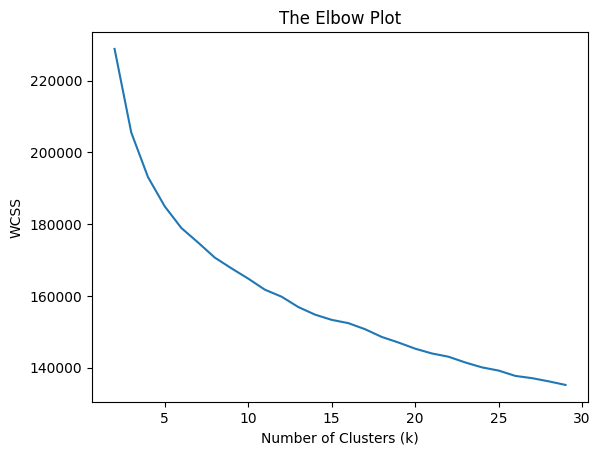

In [ ]:
# now we need to find optimal number of clusters
# for k ranges from 2 to 30, fit on "features" to generate an elbow plot
wcss = []
for k in range(2, 30):
  kmeans = KMeans(n_clusters=k, random_state=0, n_init=5)
  kmeans.fit(features_scaled)
  wcss.append(kmeans.inertia_)
plt.plot(range(2,30),wcss)
plt.title('The Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')

In [ ]:
#Chose 20 clusters since no obvious elbow
kmeans = KMeans(n_clusters=20, random_state=0, n_init=5)

## 2.2 Training Model

In [ ]:
kmeans_model = kmeans.fit(features_scaled)
clusters = kmeans_model.predict(features_scaled)
clusters

array([ 7,  4, 19, ...,  5,  6, 15], dtype=int32)

## 2.3 Categorizing Each Row into Clusters

In [ ]:
#add cluster number into a new column matching the row
df_survey_public_rec_cond_6['cluster'] = clusters.tolist()

In [ ]:
df_cluster = df_survey_public_rec_cond_6[['cluster', 'Languages', 'Databases', 'Platforms', 'Webframe', 'MiscTech']]

In [ ]:
#Combine all technologies into a list for each cluster
df_cluster_temp = df_cluster.groupby('cluster').agg(lambda x: x)

In [ ]:
df_cluster_temp.iloc[1,0]

array([list(['Elixir', 'Erlang', 'HTML/CSS', 'JavaScript', 'Ruby', 'SQL', 'TypeScript']),
       list(['C#', 'SQL', 'TypeScript']),
       list(['Java', 'JavaScript', 'PHP', 'SQL', 'TypeScript']), ...,
       list(['Clojure']),
       list(['Bash/Shell', 'C#', 'Dart', 'PowerShell']),
       list(['Java', 'JavaScript', 'SQL'])], dtype=object)

In [ ]:
# Flatten the double list in each of our technologies
# this provides a list of values per cluster in each of the lists
def flatten(x):
  flat_list= []
  for sublist in x:
    if isinstance(sublist, list):
      for item in sublist:
        flat_list.append(item)
  return flat_list

df_cluster_temp['Languages List'] = df_cluster_temp['Languages'].apply(lambda x: flatten(x))
df_cluster_temp['Databases List'] = df_cluster_temp['Databases'].apply(lambda x: flatten(x))
df_cluster_temp['Platforms List'] = df_cluster_temp['Platforms'].apply(lambda x: flatten(x))
df_cluster_temp['Webframe List'] = df_cluster_temp['Webframe'].apply(lambda x: flatten(x))
df_cluster_temp['MiscTech List'] = df_cluster_temp['MiscTech'].apply(lambda x: flatten(x))

In [ ]:
df_cluster_final = df_cluster_temp.drop(columns=['Languages', 'Databases', 'Platforms', 'Webframe', 'MiscTech'])

In [ ]:
df_cluster_final

,Languages List,Databases List,Platforms List,Webframe List,MiscTech List
cluster,,,,,
0,"[C++, Lua, MATLAB, Python, Bash/Shell, HTML/CS...","[MySQL, MySQL, MySQL, Oracle, MySQL, MongoDB, ...","[DigitalOcean, Heroku, Firebase, Heroku, AWS, ...","[ASP.NET, ASP.NET Core , Node.js, Vue.js, Expr...","[NumPy, Scikit-learn, Torch/PyTorch, .NET, Num..."
1,"[Elixir, Erlang, HTML/CSS, JavaScript, Ruby, S...","[DynamoDB, PostgreSQL, Microsoft SQL Server, P...","[AWS, Heroku, Google Cloud, Microsoft Azure, A...","[jQuery, Next.js, Node.js, Phoenix, React.js, ...","[.NET, .NET, .NET, Apache Spark, NumPy, Pandas..."
2,"[HTML/CSS, JavaScript, SQL, Go, JavaScript, Py...","[Microsoft SQL Server, MongoDB, Couchbase, Pos...","[Heroku, Microsoft Azure, AWS, DigitalOcean, G...","[Express, jQuery, Node.js, React.js, Express, ...","[Electron, React Native, NumPy, Pandas, NumPy,..."
3,"[C#, HTML/CSS, JavaScript, PowerShell, Python,...","[Couchbase, CouchDB, Microsoft SQL Server, Mon...","[AWS, Microsoft Azure, Firebase, Google Cloud,...","[ASP.NET, ASP.NET Core , Express, Node.js, Vue...","[.NET, Keras, NumPy, Pandas, Scikit-learn, Ten..."
4,"[C#, JavaScript, SQL, TypeScript, C#, HTML/CSS...","[Microsoft SQL Server, Microsoft SQL Server, M...","[Microsoft Azure, AWS, VMware, Google Cloud, M...","[ASP.NET, ASP.NET Core , ASP.NET, Angular, Ang...","[.NET, .NET, Apache Kafka, Spring, NumPy, Pand..."
5,"[C#, C++, HTML/CSS, JavaScript, SQL, TypeScrip...","[MongoDB, MySQL, SQLite, Oracle, Couchbase, Co...","[AWS, Managed Hosting, Microsoft Azure, Digita...","[ASP.NET, ASP.NET Core , jQuery, Gatsby, React...","[.NET, Xamarin, Electron, Flutter, .NET, Apach..."
6,"[C, HTML/CSS, Rust, SQL, Swift, TypeScript, Py...","[PostgreSQL, MySQL, Redis, SQLite, MySQL, Post...","[AWS, Google Cloud, OVH, VMware, Microsoft Azu...","[React.js, Angular, FastAPI, Vue.js, Drupal, j...","[Torch/PyTorch, NumPy, Pandas, Qt, Apache Spar..."
7,"[C#, C++, HTML/CSS, JavaScript, Python, Bash/S...","[Microsoft SQL Server, Microsoft SQL Server, M...","[AWS, Microsoft Azure, AWS, Microsoft Azure, M...","[Angular.js, ASP.NET, ASP.NET Core , Vue.js, E...","[Pandas, .NET, .NET, Apache Kafka, Flutter, Sp..."
8,"[Bash/Shell, Julia, Python, Dart, HTML/CSS, Ja...","[MySQL, PostgreSQL, SQLite, MySQL, Microsoft S...","[Microsoft Azure, AWS, Heroku, Oracle Cloud In...","[Node.js, Express, Flask, Node.js, Vue.js, Exp...","[NumPy, Scikit-learn, Torch/PyTorch, Flutter, ..."


## 2.4 Analyzing Clusters

With the cluster data now complete, we can analyze some of the clusters to understand more how the model has separated the data

In [ ]:
# this function will be used to sort the languages/frameworks/etc from most popular to least popular
def highest_count(skills):
  tech_map = {}
  for tech in skills:
    if tech in tech_map:
      count = tech_map[tech]
      count += 1
      tech_map[tech] = count
    else:
      tech_map[tech] = 1
  return dict(sorted(tech_map.items(), key=lambda item: item[1], reverse=True))

Let's examine the top 5 languages/webframes/databases in each cluster

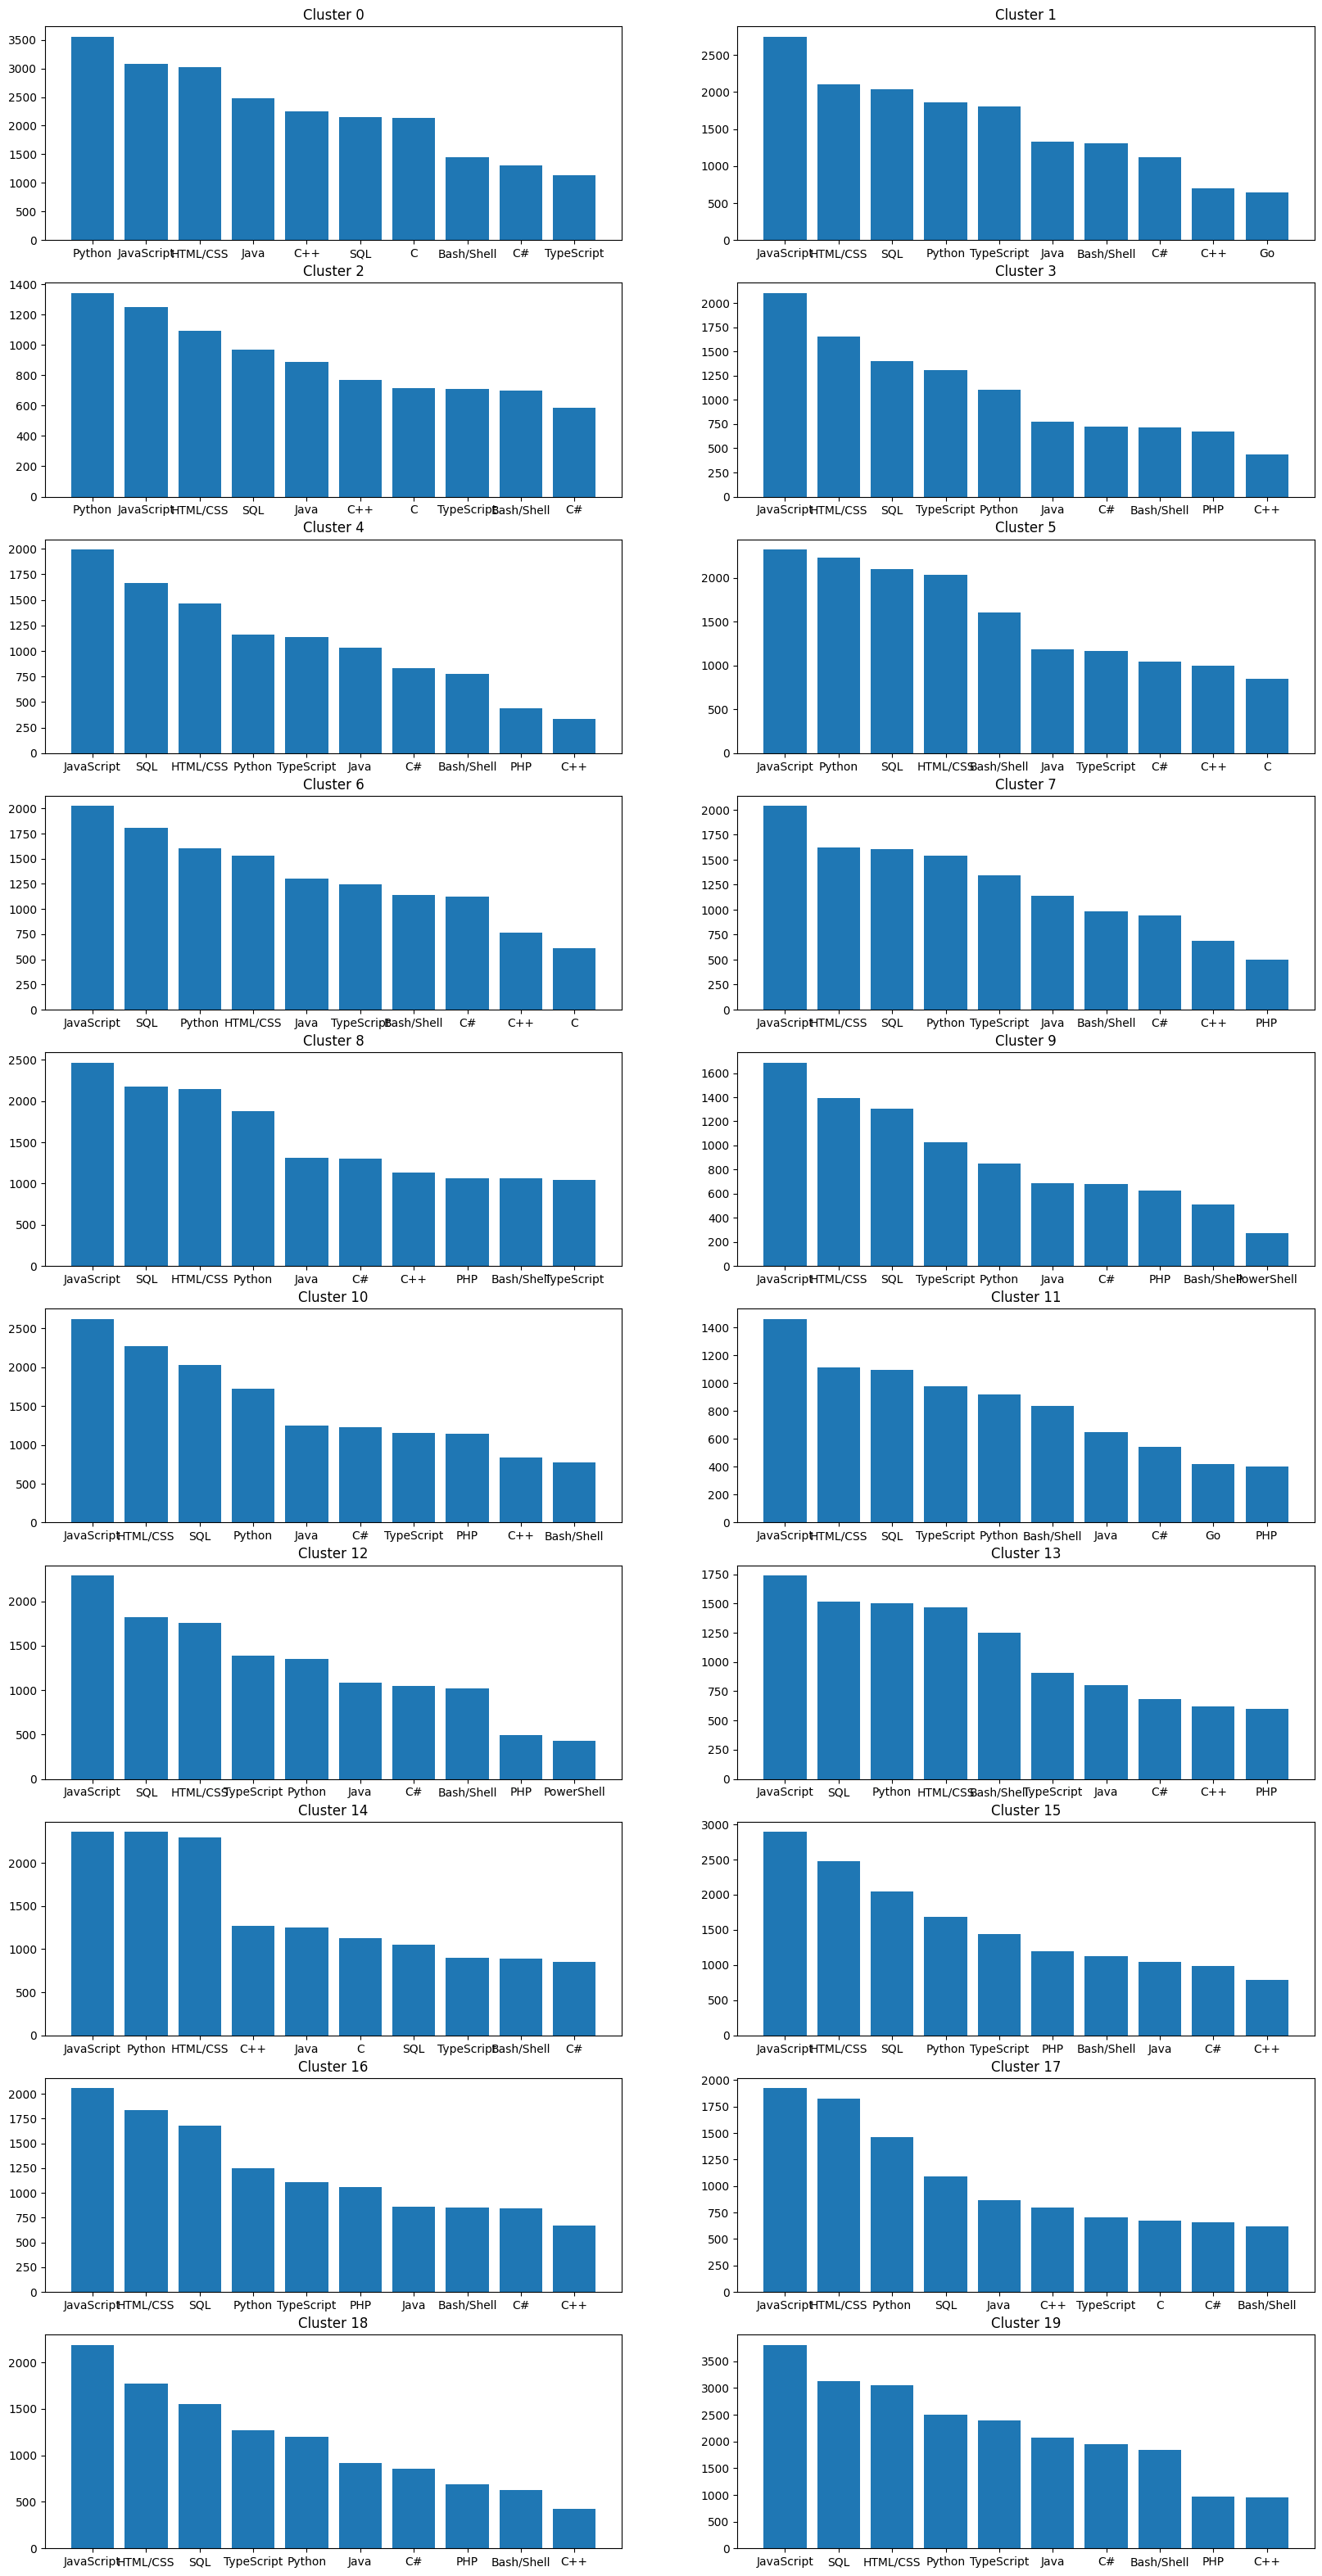

In [ ]:
cluster_lang = [0 for i in range(20)]
for i in range(20):
  cluster_lang[i] = highest_count(df_cluster_final['Languages List'].iloc[i])
  cluster_lang[i] = dict(list(cluster_lang[i].items())[:10]) # only keep top 10
fig, ax = plt.subplots(10, 2)
fig.set_figwidth(20)
fig.set_figheight(40)
for i in range(10):
  for j in range(2):
    keys = list(cluster_lang[i * 2 + j].keys())
    values = list(cluster_lang[i * 2 + j].values())
    ax[i, j].bar(range(len(keys)), values, tick_label=keys)
    ax[i, j].set_title("Cluster " + str(i * 2 + j))

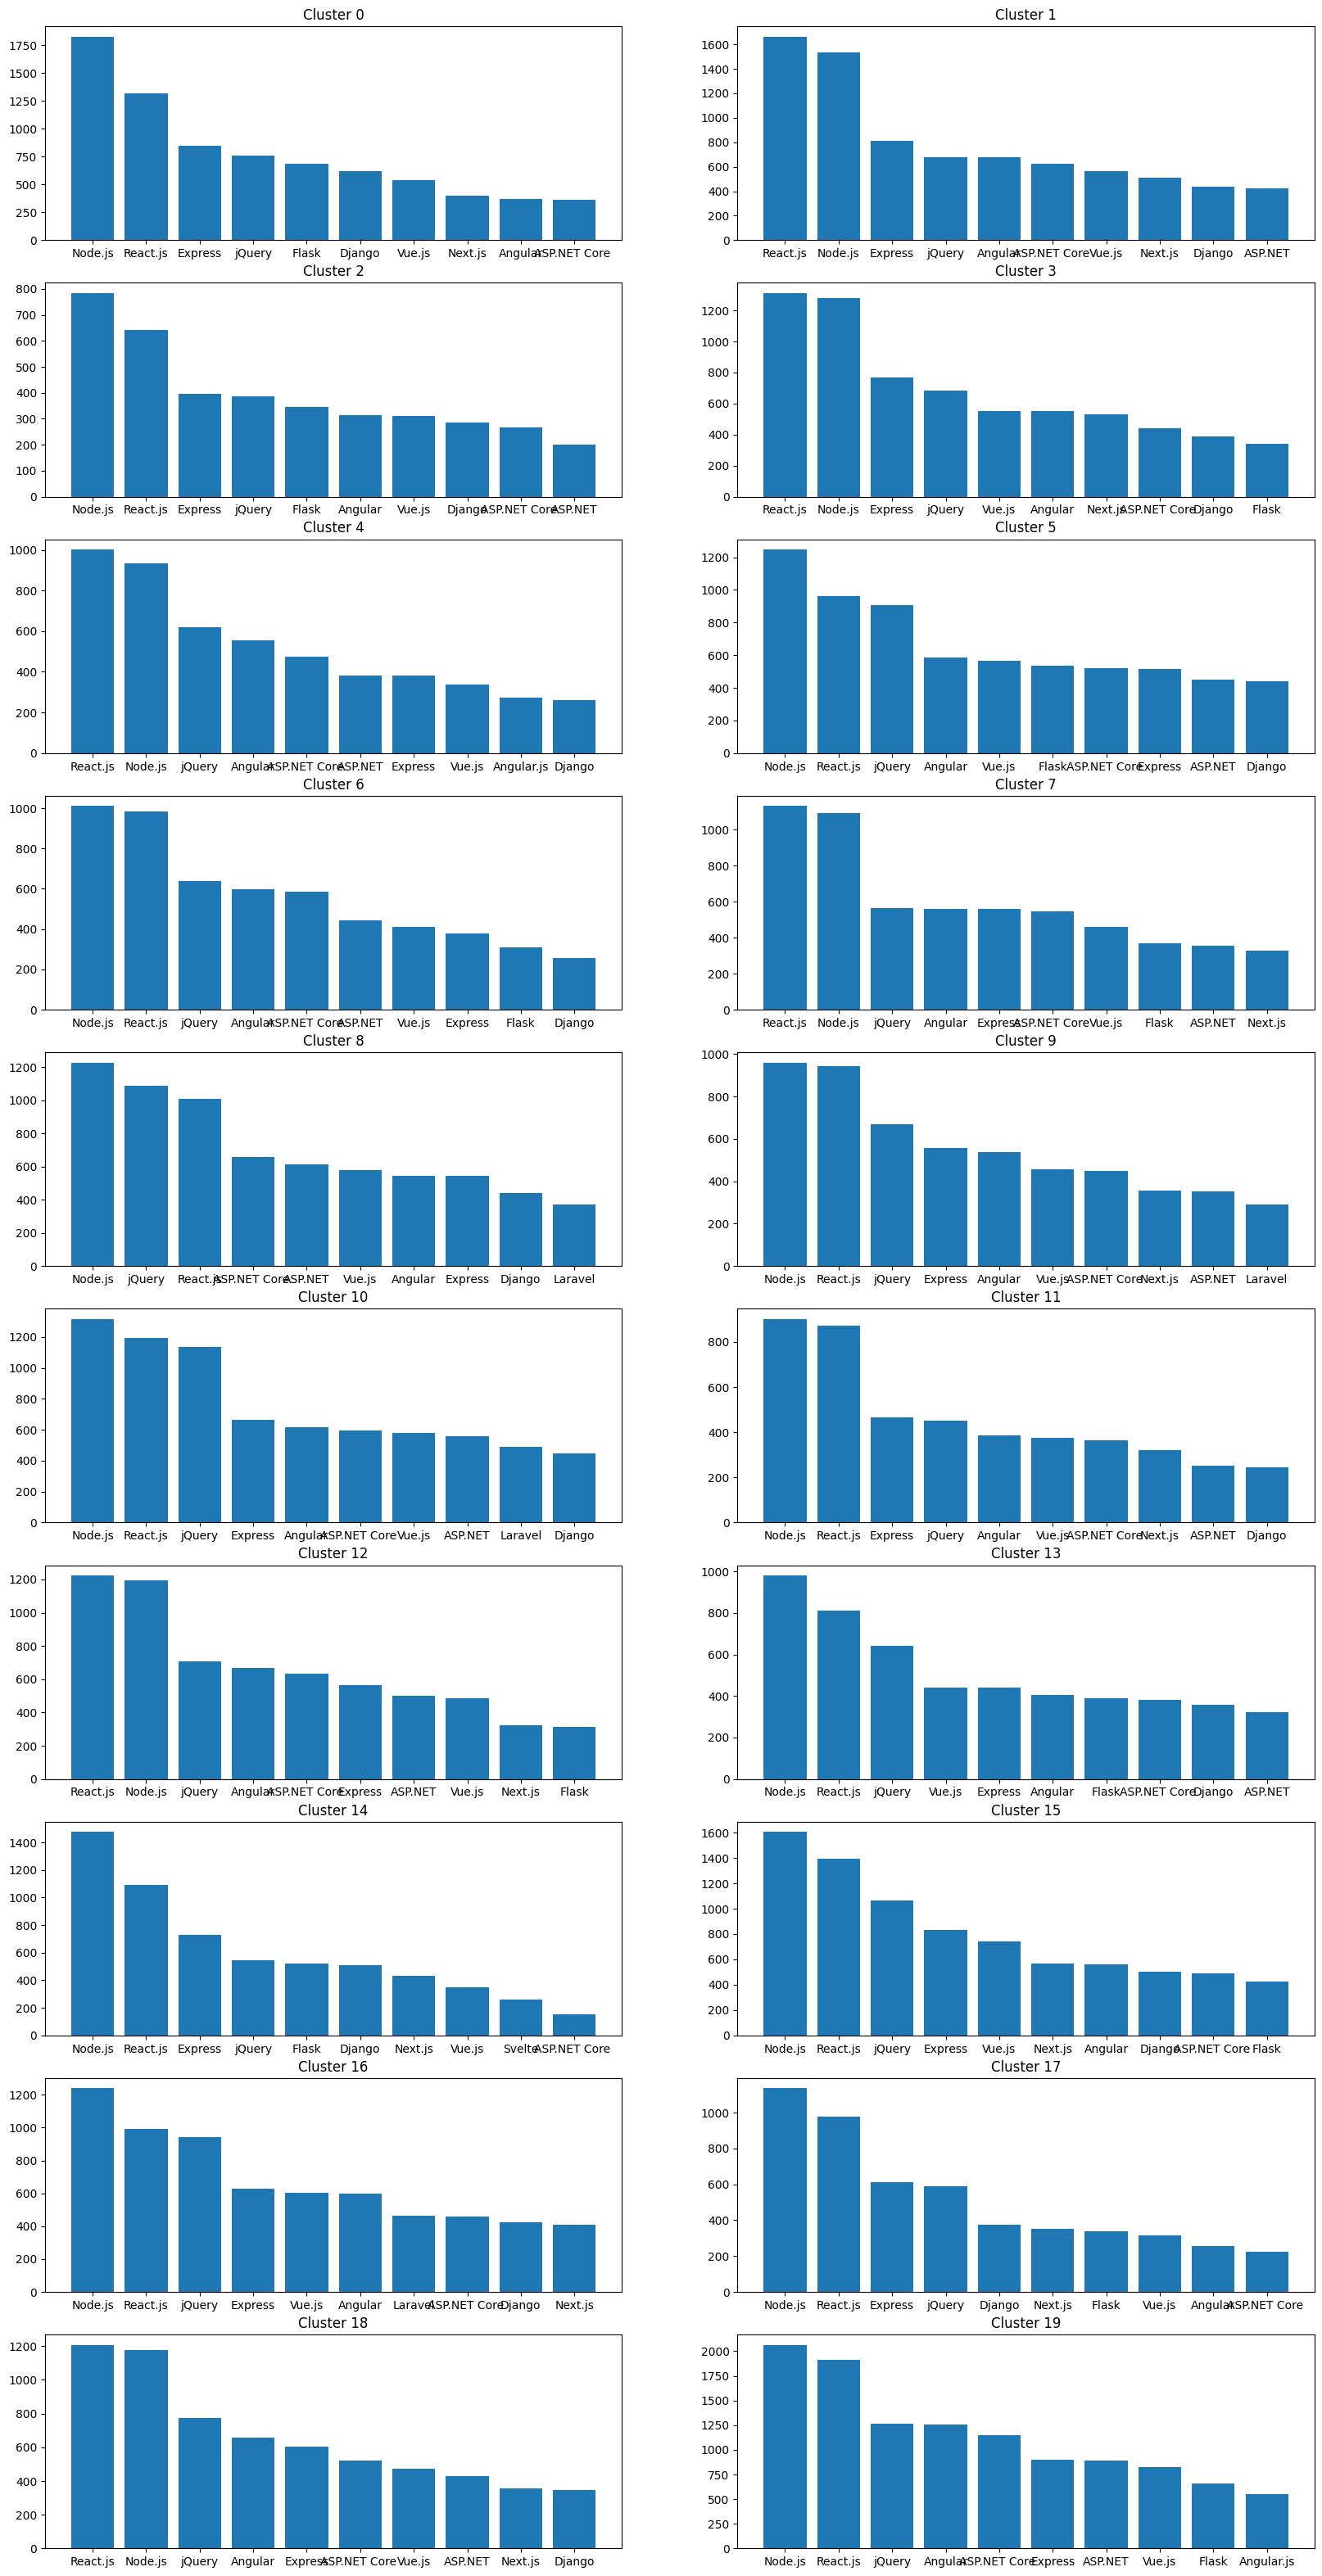

In [ ]:
cluster_wf = [0 for i in range(20)]
for i in range(20):
  cluster_wf[i] = highest_count(df_cluster_final['Webframe List'].iloc[i])
  cluster_wf[i] = dict(list(cluster_wf[i].items())[:10]) # only keep top 10
fig, ax = plt.subplots(10, 2)
fig.set_figwidth(20)
fig.set_figheight(40)
for i in range(10):
  for j in range(2):
    keys = list(cluster_wf[i * 2 + j].keys())
    values = list(cluster_wf[i * 2 + j].values())
    ax[i, j].bar(range(len(keys)), values, tick_label=keys)
    ax[i, j].set_title("Cluster " + str(i * 2 + j))

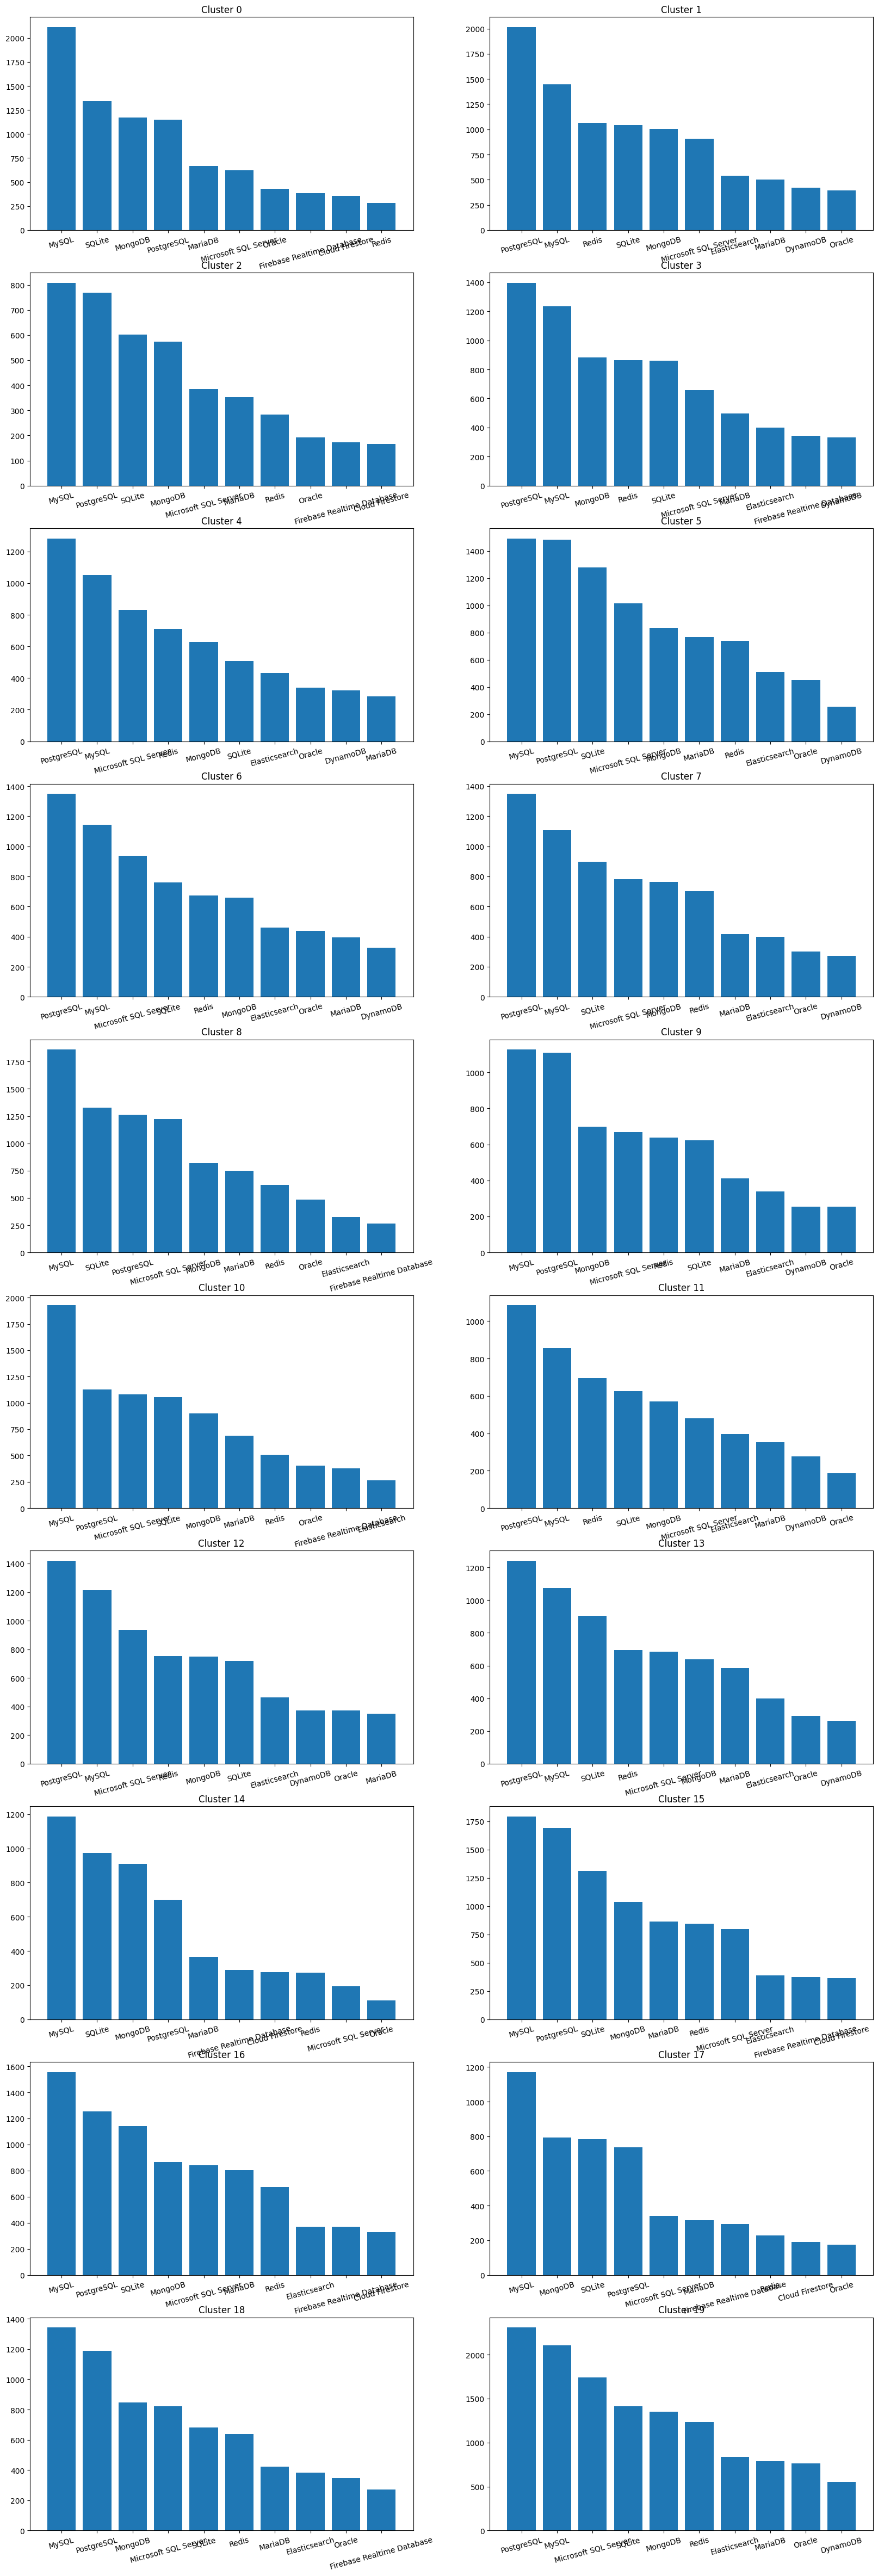

In [ ]:
cluster_data = [0 for i in range(20)]
for i in range(20):
  cluster_data[i] = highest_count(df_cluster_final['Databases List'].iloc[i])
  cluster_data[i] = dict(list(cluster_data[i].items())[:10]) # only keep top 10
fig, ax = plt.subplots(10, 2)
fig.set_figwidth(20)
fig.set_figheight(60)
for i in range(10):
  for j in range(2):
    keys = list(cluster_data[i * 2 + j].keys())
    values = list(cluster_data[i * 2 + j].values())
    ax[i, j].bar(range(len(keys)), values, tick_label=keys)
    ax[i, j].set_title("Cluster " + str(i * 2 + j))
    ax[i, j].tick_params(axis='x', labelrotation = 15)

You will notice a fair bit of overlap in the clusters. This is expected since some languages/webframes/databases are very popular. We can notice the difference for less popular technologies. Clusters with more people that know C, C#, or C++ tend to have higher ASP.NET usage. And Clusters with more Python tend to have more Flask and Django usage.

# **Part 3: Testing the Recommendation Engine**

In K-Means clustering, we don't have a set of test data because we cannot label the expected cluster ahead of time. Instead, we will test several hypothetical profiles and see if the learning recommendations make sense.

## Sample User 1

In [ ]:
dan = {'YearsCodePro': 0, 'Employed': 0, 'Student': 1, 'Contractor': 0, 'NotEmployed': 0, 'Retired': 0, 'Remote': 1, 'Hybrid': 0, 'InPerson': 0,
          'CodingHobby': 0, 'CodingProjects': 1, 'CodingSideBusiness': 0, 'CodingSideSchool': 1, 'CodingOther': 0, 'LearnBooks': 0, 'LearnFriendFamily': 1,
          'LearnOnline': 1, 'LearnSchool': 1, 'LearnJob': 0, 'LearnBootcamp': 0, 'LearnHackathon': 0, 'LearnOther': 0, 'YearsCodeOther': 3, 'TypeDevEng': 1,
          'TypeData': 0, 'TypeManager': 0, 'TypeOther': 0, 'AgeNum': 33, 'UpdatedOrgSize': 1}
dan_df = pd.DataFrame(data=dan, index=[0])
dan_df


,YearsCodePro,Employed,Student,Contractor,NotEmployed,Retired,Remote,Hybrid,InPerson,CodingHobby,...,LearnBootcamp,LearnHackathon,LearnOther,YearsCodeOther,TypeDevEng,TypeData,TypeManager,TypeOther,AgeNum,UpdatedOrgSize
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,3,1,0,0,0,33,1


In [ ]:
#scale
df_features_with_user_scaled = mms_trained.transform(dan_df)

#Use the kmeans model and predict what cluster the user will be in
user_clusters = kmeans_model.predict(df_features_with_user_scaled)[0]
user_clusters

0

In [ ]:
#Getting all the tech skills that the user has
languages_dan = ['JavaScript', 'Python', 'HTML/CSS', 'Java', 'SQL']
databases_dan = ['SQLite', 'MySQL']
platforms_dan = ['AWS']
webframe_dan = ['React.js', 'Node.js']
misctech_dan = ['NumPy', 'Pandas']

In [ ]:
#Getting the most used tech in the cluster that the user is in. In this case, it is cluster #0
languages_dan_map = highest_count(df_cluster_final['Languages List'].iloc[user_clusters])
databases_dan_map = highest_count(df_cluster_final['Databases List'].iloc[user_clusters])
platforms_dan_map = highest_count(df_cluster_final['Platforms List'].iloc[user_clusters])
webframe_dan_map = highest_count(df_cluster_final['Webframe List'].iloc[user_clusters])
misctech_dan_map = highest_count(df_cluster_final['MiscTech List'].iloc[user_clusters])

In [ ]:
# function to remove skills user already have
def remove_user_skill_from_cluster_map(user_skills, cluster_map):
  for skill in user_skills:
    if skill in cluster_map:
      cluster_map.pop(skill)


remove_user_skill_from_cluster_map(languages_dan, languages_dan_map)
remove_user_skill_from_cluster_map(databases_dan, databases_dan_map)
remove_user_skill_from_cluster_map(platforms_dan, platforms_dan_map)
remove_user_skill_from_cluster_map(webframe_dan, webframe_dan_map)
remove_user_skill_from_cluster_map(misctech_dan, misctech_dan_map)

In [ ]:
#Getting final recommendation!
#Get recommendation by getting the highest count of the skill that the user does not currently have
print('The recommended language to learn is: ', next(iter(languages_dan_map)))
print('The recommended datatbase to learn is: ', next(iter(databases_dan_map)))
print('The recommended platform to learn is: ', next(iter(platforms_dan_map)))
print('The recommended webframe to learn is: ', next(iter(webframe_dan_map)))
print('The recommended misc tech to learn is: ', next(iter(misctech_dan_map)))

The recommended language to learn is:  C++
The recommended datatbase to learn is:  MongoDB
The recommended platform to learn is:  Heroku
The recommended webframe to learn is:  Express
The recommended misc tech to learn is:  .NET


The above recommendation makes sense because you can see that C++ in cluster 0 is the fifth most used language. MongoDB is the third most used database in cluster 0 and dan already knows MySQL and SQLite. Learning Express will complement his existing knowledge of React and Node.

## Sample User 2

In [ ]:
#sample user 2
roger = {'YearsCodePro': 35, 'Employed': 1, 'Student': 0, 'Contractor': 0, 'NotEmployed': 0, 'Retired': 0, 'Remote': 0, 'Hybrid': 1, 'InPerson': 0,
          'CodingHobby': 0, 'CodingProjects': 1, 'CodingSideBusiness': 0, 'CodingSideSchool': 0, 'CodingOther': 1, 'LearnBooks': 1, 'LearnFriendFamily': 1,
          'LearnOnline': 0, 'LearnSchool': 0, 'LearnJob': 1, 'LearnBootcamp': 0, 'LearnHackathon': 0, 'LearnOther': 0, 'YearsCodeOther': 2, 'TypeDevEng': 0,
          'TypeData': 1, 'TypeManager': 0, 'TypeOther': 0, 'AgeNum': 65, 'UpdatedOrgSize': 15000}
roger_df = pd.DataFrame(data=roger, index=[0])
roger_df

,YearsCodePro,Employed,Student,Contractor,NotEmployed,Retired,Remote,Hybrid,InPerson,CodingHobby,...,LearnBootcamp,LearnHackathon,LearnOther,YearsCodeOther,TypeDevEng,TypeData,TypeManager,TypeOther,AgeNum,UpdatedOrgSize
0,35,1,0,0,0,0,0,1,0,0,...,0,0,0,2,0,1,0,0,65,15000


In [ ]:
#scale
df_features_with_user_scaled_2 = mms_trained.transform(roger_df)

#Use the kmeans model and predict what cluster the user will be in
user_clusters = kmeans_model.predict(df_features_with_user_scaled_2)[0]
user_clusters

6

In [ ]:
#Getting all the tech skills that the user has
languages_roger = ['C++', 'SQL']
databases_roger = ['SQLite', 'MySQL']
platforms_roger = []
webframe_roger = []
misctech_roger = []

In [ ]:
#Getting the most used tech in the cluster that the user is in. In this case, it is cluster #6
languages_roger_map = highest_count(df_cluster_final['Languages List'].iloc[user_clusters])
databases_roger_map = highest_count(df_cluster_final['Databases List'].iloc[user_clusters])
platforms_roger_map = highest_count(df_cluster_final['Platforms List'].iloc[user_clusters])
webframe_roger_map = highest_count(df_cluster_final['Webframe List'].iloc[user_clusters])
misctech_roger_map = highest_count(df_cluster_final['MiscTech List'].iloc[user_clusters])

In [ ]:
remove_user_skill_from_cluster_map(languages_roger, languages_roger_map)
remove_user_skill_from_cluster_map(databases_roger, databases_roger_map)
remove_user_skill_from_cluster_map(platforms_roger, platforms_roger_map)
remove_user_skill_from_cluster_map(webframe_roger, webframe_roger_map)
remove_user_skill_from_cluster_map(misctech_roger, misctech_roger_map)

In [ ]:
#Getting final recommendation!
#Get recommendation by getting the highest count of the skill that the user does not currently have
print('The recommended language to learn is: ', next(iter(languages_roger_map)))
print('The recommended datatbase to learn is: ', next(iter(databases_roger_map)))
print('The recommended platform to learn is: ', next(iter(platforms_roger_map)))
print('The recommended webframe to learn is: ', next(iter(webframe_roger_map)))
print('The recommended misc tech to learn is: ', next(iter(misctech_dan_map)))

The recommended language to learn is:  JavaScript
The recommended datatbase to learn is:  PostgreSQL
The recommended platform to learn is:  AWS
The recommended webframe to learn is:  Node.js
The recommended misc tech to learn is:  NumPy


Roger has been working for a long time, but he is lacking knowledge on many of the most popular languages today. C++ is a backend language and SQL covers databases, so the recommendation engine is correct to recommend Roger learn Javascript for a frontend language to show his tables and charts at work.